In [2]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [10]:
# VIDEO FEED
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow('Mediapipe Feed', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [3]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [8]:

cap = cv2.VideoCapture(0)

# Curl counter variables
counter = 0 
stage = None

## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence = 0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        
        # 設置人形的高度（以像素為單位）
        height = 330 # 假設每像素代表 0.5 公分

        
        
        # Extract landmarks
        try:
            
            
            
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
            
            # Calculate angle
            angle = calculate_angle(hip, knee, ankle)
            
            # Visualize angle
            cv2.putText(image, str(angle), 
                           tuple(np.multiply(knee, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
            
            # Curl counter logic
            if angle > 135:
                stage = "up"
            if angle < 110 and stage =='up':
                stage="down"
                counter +=1
                print(counter)
                       
        except:
            pass
        
        # Render curl counter
        # Setup status box
        cv2.rectangle(image, (0,0), (225,73), (245,117,16), -1)
        
        # Rep data
        cv2.putText(image, 'REPS', (15,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(counter), 
                    (10,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        
        # Stage data
        cv2.putText(image, 'STAGE', (65,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, stage, 
                    (60,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        
        
        # 獲取影像的尺寸
        h, w = frame.shape[:2]
        # 繪製人形
        # 創建一個空白圖層
        overlay = np.zeros_like(image)

        # 繪製人形
        # 頭部
        cv2.ellipse(overlay, (w//2, int(h*0.15)), (int(w*0.1), int(h*0.1)), 0, 0, 360, (255, 255, 255), -1)
        # 身體
        cv2.rectangle(overlay, (w//2-int(w*0.05), int(h*0.15)), (w//2+int(w*0.05), int(h*0.4)), (255, 255, 255), -1)
        # 四肢
        limbs = [
            [(w//2-int(w*0.05), int(h*0.25)), (w//2-int(w*0.25), int(h*0.25))], # 左臂
            [(w//2+int(w*0.05), int(h*0.25)), (w//2+int(w*0.25), int(h*0.25))], # 右臂
            [(w//2-int(w*0.025), int(h*0.4)), (w//2-int(w*0.025), h)], # 左腿
            [(w//2+int(w*0.025), int(h*0.4)), (w//2+int(w*0.025), h)]  # 右腿
        ]
        for limb in limbs:
            cv2.line(overlay, *limb, (255, 255, 255), 5)

        # 將人形圖層與原始影像融合（設置透明度為 0.5）
        alpha = 0.5
        cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)



        
        
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

1
2
3
4
5
6
7


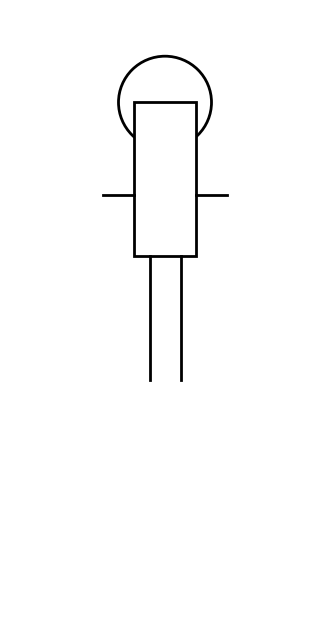

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

fig, ax = plt.subplots(figsize=(4, 8))

# 設置背景顏色
ax.set_facecolor('xkcd:sky blue')

# 設置坐標軸範圍
ax.set_xlim(0, 10)
ax.set_ylim(0, 20)

# 隱藏坐標軸
ax.axis('off')

# 繪製頭部
head = Circle((5, 17), radius=1.5, fc='white', ec='black', linewidth=2)
ax.add_patch(head)

# 繪製身體
body = Rectangle((4, 12), 2, 5, fc='white', ec='black', linewidth=2)
ax.add_patch(body)

# 繪製四肢
limbs = [
    ((3, 14), (4, 14)), # 左臂
    ((6, 14), (7, 14)), # 右臂
    ((4.5, 8), (4.5, 12)), # 左腿
    ((5.5, 8), (5.5, 12)) # 右腿
]
for limb in limbs:
    ax.plot(*zip(*limb), color='black', linewidth=2)

plt.show()
